# FACTR – Feedback Inspector

This notebook analyses user feedback stored in `factr_verdict_feedback.jsonl`.

It is designed to produce a set of figures and tables that you can copy into the
dissertation (Results / Evaluation chapter).

In [1]:
from pathlib import Path
import json
import pandas as pd
import matplotlib.pyplot as plt

# Display plots inline
%matplotlib inline

# Optional: tweak default figure size
plt.rcParams['figure.figsize'] = (8, 4)


## 1. Load feedback data

Adjust `feedback_path` if your file lives somewhere else (e.g. on RunPod it might be
`data/processed/factr_verdict_feedback.jsonl`).

In [3]:
feedback_path = Path(r"C:\Users\lukmaan\Downloads\factr_verdict_feedback.jsonl")  # change if needed

rows = []
if not feedback_path.is_file():
    raise FileNotFoundError(f'Cannot find feedback file at {feedback_path!r}. '
                            'Update feedback_path to the correct location.')

with feedback_path.open('r', encoding='utf-8') as f:
    for line in f:
        rows.append(json.loads(line))

fb = pd.DataFrame(rows)
fb['timestamp'] = pd.to_datetime(fb['timestamp'])
fb.head()

,timestamp,claim_id,claim_text,verdict_islam,verdict_christian,verdict_overall,confidence,reaction,comment,user_tag
0,2025-12-12 11:42:05,8ba76dad_000,"According to Jesus, the true God is three pers...",disagrees,agrees,conflicted,0.9,thumbs_up,None,lukmaan
1,2025-12-12 11:43:33,8ba76dad_001,Jesus is all three persons of the true God.,disagrees,agrees,conflicted,0.9,thumbs_up,None,lukmaan
2,2025-12-12 11:53:11,8ba76dad_000,"According to Jesus, the true God is three pers...",disagrees,agrees,conflicted,0.9,thumbs_up,None,lukmaan
3,2025-12-12 11:54:40,8ba76dad_000,"According to Jesus, the true God is three pers...",disagrees,agrees,conflicted,0.9,thumbs_down,does not make sense because the bible verses a...,lukmaan
4,2025-12-12 11:55:48,8ba76dad_001,Jesus is all three persons of the true God.,disagrees,agrees,conflicted,0.9,thumbs_down,ok but needs enhancing,lukmaan


In [4]:
print('Total feedback rows:', len(fb))
print('Distinct users (user_tag):', fb['user_tag'].nunique())
print('Distinct claims:', fb['claim_id'].nunique())

Total feedback rows: 20
Distinct users (user_tag): 3
Distinct claims: 10


## 2. Overall verdict and reaction distributions

These plots give a quick overview of how FACTR is behaving and how testers are
responding to the verdicts. They are good candidates for a figure in the
dissertation.

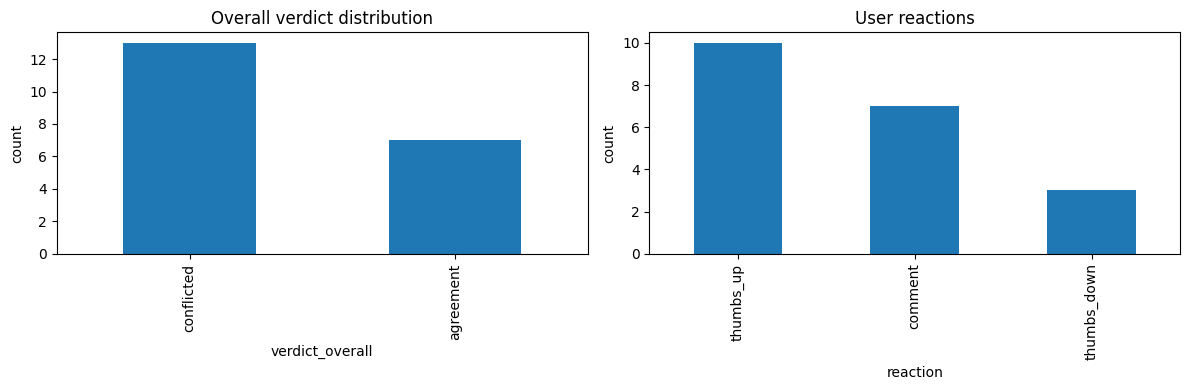

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Verdict distribution
fb['verdict_overall'].value_counts().plot(kind='bar', ax=axes[0])
axes[0].set_title('Overall verdict distribution')
axes[0].set_xlabel('verdict_overall')
axes[0].set_ylabel('count')

# Reaction distribution (thumbs up / down)
fb['reaction'].value_counts().plot(kind='bar', ax=axes[1])
axes[1].set_title('User reactions')
axes[1].set_xlabel('reaction')
axes[1].set_ylabel('count')

plt.tight_layout()
plt.show()

## 3. Agreement between verdict and user reaction

Here we look at how often testers give a thumbs-up vs thumbs-down for each type
of overall verdict. This is essentially a sanity check on whether the scoring
system aligns with human judgement.

In [6]:
crosstab = pd.crosstab(
    fb['verdict_overall'],
    fb['reaction'],
    normalize='index'
)
crosstab.style.format('{:.0%}')

reaction,comment,thumbs_down,thumbs_up
verdict_overall,,,
agreement,43%,14%,43%
conflicted,31%,15%,54%


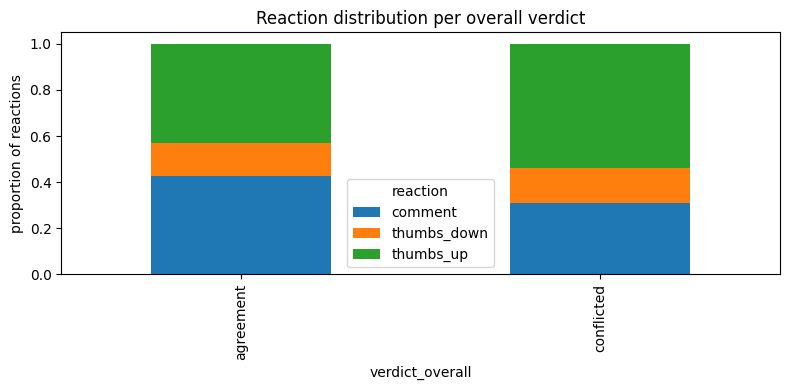

In [7]:
ax = crosstab.plot(kind='bar', stacked=True)
ax.set_title('Reaction distribution per overall verdict')
ax.set_ylabel('proportion of reactions')
plt.tight_layout()
plt.show()

## 4. Confidence vs user reaction

This boxplot shows whether higher-confidence verdicts tend to attract more
positive feedback. In the write-up you can quote approximate medians.

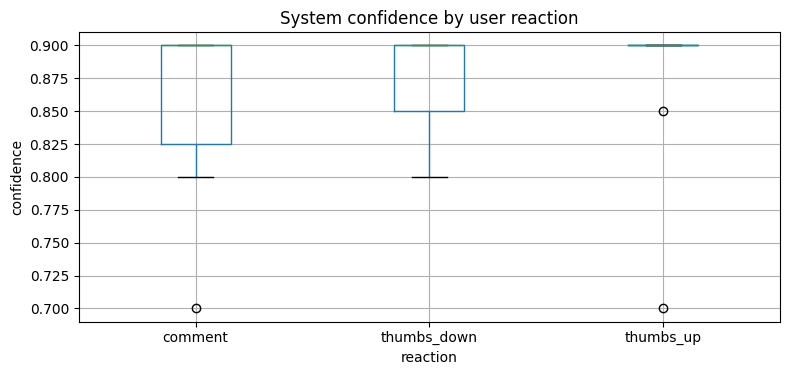

In [8]:
fig, ax = plt.subplots()
fb.boxplot(column='confidence', by='reaction', ax=ax)
ax.set_title('System confidence by user reaction')
ax.set_xlabel('reaction')
ax.set_ylabel('confidence')
plt.suptitle('')  # remove automatic pandas title
plt.tight_layout()
plt.show()

## 5. Claim-level agreement and most controversial claims

We aggregate feedback per claim to find which claims have the strongest and
weakest agreement. This is useful for a short table in the dissertation and
         for qualitative discussion with concrete examples.

In [9]:
claim_stats = (
    fb.groupby(['claim_id', 'claim_text'])
      .agg(
          n_feedback=('reaction', 'size'),
          n_up=('reaction', lambda s: (s == 'thumbs_up').sum()),
          n_down=('reaction', lambda s: (s == 'thumbs_down').sum()),
          mean_confidence=('confidence', 'mean'),
      )
      .assign(agree_ratio=lambda df: df['n_up'] / df['n_feedback'])
      .reset_index()
)
claim_stats.head()

,claim_id,claim_text,n_feedback,n_up,n_down,mean_confidence,agree_ratio
0,8ba76dad_000,"According to Jesus, the true God is three pers...",3,2,1,0.9,0.666667
1,8ba76dad_001,Jesus is all three persons of the true God.,2,1,1,0.9,0.500000
2,8ba76dad_002,People should worship God instead of any creat...,1,1,0,0.9,1.000000
3,8f2858f0_001,Jesus is all three persons of the true God.,2,1,0,0.9,0.500000
4,8f2858f0_002,"Jesus is my friend, counselor, and listener wh...",2,0,1,0.8,0.000000


In [10]:
# Claims with strongest agreement (mostly thumbs_up)
top_agree = (
    claim_stats
    .query('n_feedback >= 3')
    .sort_values(['agree_ratio', 'n_feedback'], ascending=[False, False])
    .head(10)
)
top_agree

,claim_id,claim_text,n_feedback,n_up,n_down,mean_confidence,agree_ratio
0,8ba76dad_000,"According to Jesus, the true God is three pers...",3,2,1,0.9,0.666667


In [11]:
# "Most controversial" claims (roughly 50/50 split)
controversial = (
    claim_stats
    .query('n_feedback >= 3')
    .assign(diff=lambda df: (df['agree_ratio'] - 0.5).abs())
    .sort_values(['diff', 'n_feedback'])
    .head(10)
    .drop(columns='diff')
)
controversial

,claim_id,claim_text,n_feedback,n_up,n_down,mean_confidence,agree_ratio
0,8ba76dad_000,"According to Jesus, the true God is three pers...",3,2,1,0.9,0.666667


## 6. Feedback volume over time (optional)

If you had multiple user-testing sessions, this shows how feedback volume
evolved over time. If your testing window was short, this may collapse into
a single bar.

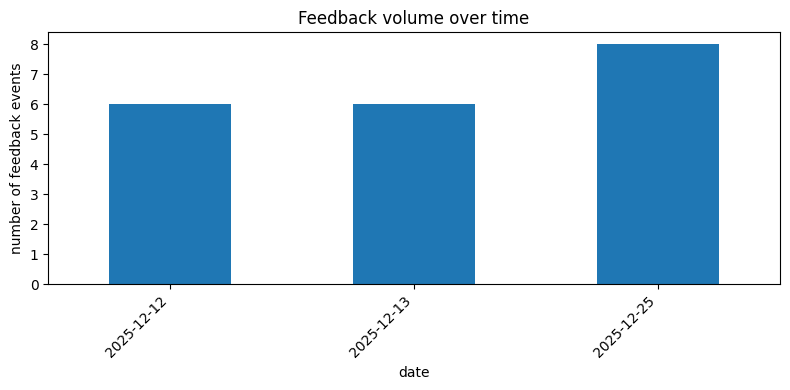

In [12]:
fb['date'] = fb['timestamp'].dt.date
daily_counts = fb.groupby('date')['reaction'].count()
ax = daily_counts.plot(kind='bar')
ax.set_title('Feedback volume over time')
ax.set_xlabel('date')
ax.set_ylabel('number of feedback events')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()